# Documentation de la librairie python d'odrive

## Startup

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import odrive
from odrive.enums import *
print(odrive.__version__)

from models.actor import Actor
from environments.cartpole import CartPoleEnv


0.5.1.dev


On peut trouver des infos ici : https://github.com/madcowswe/ODrive/tree/master/tools

L'ensemble des enums : https://github.com/madcowswe/ODrive/blob/master/tools/odrive/enums.py

In [2]:
print("looking for an unpaired odrive...")
try:
    my_drive = odrive.find_any(timeout=15) # takes 8s to find.
    print("Odrive was found")
except TimeoutError:
    print("No device found")

#336731523536

looking for an unpaired odrive...
Odrive was found


## Configuration

In [12]:
for axis in [my_drive.axis1, my_drive.axis0]:

    # V 0.5.1
    axis.encoder.config.cpr = 4*600

    axis.controller.config.pos_gain = 200.0
    axis.controller.config.vel_gain = 0.02
    axis.controller.config.vel_integrator_gain = 0#.01

    axis.controller.config.vel_limit = 30
    axis.controller.config.vel_limit_tolerance = 2

    axis.controller.config.vel_ramp_rate = 1.0

    axis.motor.config.current_lim = 10
    axis.motor.config.calibration_current = 20

    axis.trap_traj.config.vel_limit = 10


    axis.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL 
    axis.controller.config.input_mode = INPUT_MODE_PASSTHROUGH#INPUT_MODE_TRAP_TRAJ

axis = my_drive.axis1
"""
axis.controller.config.control_mode = CONTROL_MODE_VELOCITY_CONTROL 
axis.controller.config.input_mode = INPUT_MODE_VEL_RAMP
"""


'\naxis.controller.config.control_mode = CONTROL_MODE_VELOCITY_CONTROL \naxis.controller.config.input_mode = INPUT_MODE_VEL_RAMP\n'

## Une façon vachement pratique de lire les propriétés des Odrives

In [7]:
axis.clear_errors()

In [4]:
axis.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE

In [8]:
axis.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

In [13]:
axis.requested_state = AXIS_STATE_IDLE

In [35]:
axis.encoder.bandwidth

error = 0x0000 (int)
is_ready = True (bool)
index_found = False (bool)
shadow_count = 2884 (int)
count_in_cpr = 484 (int)
interpolation = 0.5 (float)
phase = 0.17120909690856934 (float)
pos_estimate = 1.2017236948013306 (float)
pos_estimate_counts = 2884.13671875 (float)
pos_cpr = 0.2017671763896942 (float)
pos_cpr_counts = 484.2412109375 (float)
pos_circular = 0.20259961485862732 (float)
hall_state = 7 (int)
vel_estimate = 0.0 (float)
vel_estimate_counts = 0.0 (float)
calib_scan_response = 2739.0 (float)
pos_abs = 0 (int)
spi_error_rate = 0.0 (float)
config:
  mode = 0 (int)
  use_index = False (bool)
  find_idx_on_lockin_only = False (bool)
  abs_spi_cs_gpio_pin = 1 (int)
  zero_count_on_find_idx = True (bool)
  cpr = 2400 (int)
  offset = -1239 (int)
  pre_calibrated = False (bool)
  offset_float = -0.12815624475479126 (float)
  enable_phase_interpolation = True (bool)
  bandwidth = 1000.0 (float)
  calib_range = 0.019999999552965164 (float)
  calib_scan_distance = 50.26548385620117

## Initialisation

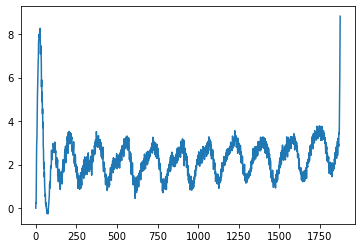

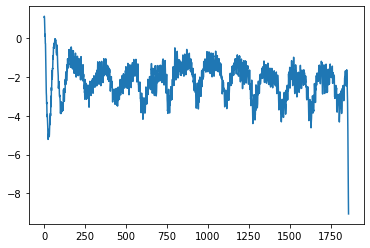

'\nsafe_min = min_pos + 0.1/(0.002*20)\nsafe_max = max_pos - 0.1/(0.002*20)\n'

In [14]:
def get_end_pos (axis, homing_speed=-5):
    
    axis.controller.config.vel_limit = 30
    axis.controller.config.vel_limit_tolerance = 2

    axis.motor.config.current_lim = 10

    axis.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL 
    axis.controller.config.input_mode = INPUT_MODE_PASSTHROUGH#INPUT_MODE_TRAP_TRAJ

    axis.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    
    start_pos = my_drive.axis1.controller.input_pos
    start_time = time.time()
    
    end_found = False
    failsafe = False
    end_pos = 0
    
    all_current = []
    while not end_found and not failsafe:
        dt = time.time()-start_time
        my_drive.axis1.controller.input_pos = start_pos + dt * homing_speed
        all_current.append(axis.motor.current_control.Iq_measured)
        if np.abs(axis.motor.current_control.Iq_measured) > 9:
            end_found = True
            end_pos = axis.encoder.pos_estimate
        if dt > 30:
            failsafe = True
    
    axis.requested_state = AXIS_STATE_IDLE
    
    plt.plot(all_current)
    plt.show()
    return end_pos

def goto (axis, abs_pos):
    
    axis.controller.config.vel_limit = 30
    axis.controller.config.vel_limit_tolerance = 2

    axis.motor.config.current_lim = 10

    axis.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL 
    axis.controller.config.input_mode = INPUT_MODE_TRAP_TRAJ
    
    axis.trap_traj.config.vel_limit = 20
    axis.trap_traj.config.accel_limit = 30
    axis.trap_traj.config.decel_limit = 30
    
    axis.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    
    my_drive.axis1.controller.input_pos = abs_pos
    move_done = False
    while not move_done:
        if np.abs(abs_pos - axis.encoder.pos_estimate) < 0.1:
            move_done = True
    
    
    axis.requested_state = AXIS_STATE_IDLE

def startup (axis):
    wakeup_pos = axis.encoder.pos_estimate
    min_pos = get_end_pos(axis, homing_speed=-5)
    goto(axis, wakeup_pos)
    max_pos = get_end_pos(axis, homing_speed=5)
    goto(axis, (min_pos+max_pos)/2)
    return min_pos, max_pos

min_pos, max_pos = startup(axis)
"""
safe_min = min_pos + 0.1/(0.002*20)
safe_max = max_pos - 0.1/(0.002*20)
"""



# Test du model entrainé en simulation

In [15]:
"""
def setup_cmd (axis):
    axis.controller.config.vel_limit = 30
    axis.controller.config.vel_limit_tolerance = 2

    axis.motor.config.current_lim = 20

    axis.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL 
    axis.controller.config.input_mode = INPUT_MODE_TRAP_TRAJ
    
    axis.trap_traj.config.accel_limit = 300
    axis.trap_traj.config.decel_limit = 300
    
    axis.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    

def set_cmd (axis, cmd_x, cmd_vel, safe_min, safe_max):
    motor_pos = axis.encoder.pos_estimate
    if motor_pos < safe_min or motor_pos > safe_max:
        axis.requested_state = AXIS_STATE_IDLE
        return False
    
    cmd_motor_pos = cmd_x/(0.002*20) + x_zero
    cmd_motor_vel = cmd_vel/(0.002*20)
    
    axis.trap_traj.config.vel_limit = cmd_motor_vel
    my_drive.axis1.controller.input_pos = cmd_motor_pos
    return True
"""


def setup_vel_cmd (axis):
    axis.controller.config.vel_limit = 30
    axis.controller.config.vel_limit_tolerance = 2

    axis.motor.config.current_lim = 20

    axis.controller.config.control_mode = CONTROL_MODE_POSITION_CONTROL 
    axis.controller.config.input_mode = INPUT_MODE_TRAP_TRAJ
    
    axis.trap_traj.config.accel_limit = 300
    axis.trap_traj.config.decel_limit = 300
    
    axis.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    

def set_vel_cmd (axis, cmd_vel, safe_min, safe_max, delta_target_pos=1):
    motor_pos = axis.encoder.pos_estimate
    """
    if motor_pos < safe_min or motor_pos > safe_max:
        axis.requested_state = AXIS_STATE_IDLE
        return False
    """
    if motor_pos < safe_min:
        cmd_vel = max(0, cmd_vel)
    if motor_pos > safe_max:
        cmd_vel = min(0, cmd_vel)
    
    cmd_motor_vel = cmd_vel/(0.002*20)
    if cmd_motor_vel > 0:
        axis.trap_traj.config.vel_limit = cmd_motor_vel
        my_drive.axis1.controller.input_pos = safe_max + delta_target_pos
    elif cmd_motor_vel < 0:
        axis.trap_traj.config.vel_limit = -cmd_motor_vel
        my_drive.axis1.controller.input_pos = safe_min - delta_target_pos
    return True

def get_state (motor_axis, encoder_axis, x_zero, a_zero):
    mot_pos = motor_axis.encoder.pos_estimate - x_zero
    mot_vel = motor_axis.encoder.vel_estimate
    enc_pos = encoder_axis.encoder.pos_estimate - a_zero
    enc_vel = encoder_axis.encoder.vel_estimate
    x = mot_pos*(0.002*20)
    v = mot_vel*(0.002*20)
    a = -enc_pos*2*np.pi
    w = -enc_vel*2*np.pi
    return x, v, a, w

env = CartPoleEnv()
env.reset()
env.bench_len=0.3

motor_axis = my_drive.axis1
encoder_axis = my_drive.axis0

a_zero = encoder_axis.encoder.pos_estimate + 0.5
x_zero = (max_pos + min_pos)/2 
safe_min = x_zero - env.x_total_max/(0.002*20)
safe_max = x_zero + env.x_total_max/(0.002*20)

print(min_pos, max_pos)
print(safe_min, safe_max)

print(env.v_max)
"""
time.sleep(3)
x, v, a, w = get_state(motor_axis, encoder_axis, x_zero, a_zero)
e = env.calc_e(x, v, a, w)
print(x, v, a, w)
print(e)
"""

-15.631745338439941 6.035671234130859
-13.548037052154541 3.951962947845459
0.5


'\ntime.sleep(3)\nx, v, a, w = get_state(motor_axis, encoder_axis, x_zero, a_zero)\ne = env.calc_e(x, v, a, w)\nprint(x, v, a, w)\nprint(e)\n'

In [ ]:
motor_axis.requested_state = AXIS_STATE_IDLE

In [47]:

#time.sleep(5)

#path = "results\\default\\models\\{}_{}"
path = "results\\exp_0\\models\\{}_{}"
   
goto(motor_axis, x_zero)

encoder_axis.encoder.config.bandwidth = 1000

actor = Actor(env)
actor.load_primitive(path)
actor.load_influence(path)

init_state = actor.get_init_state(env.num_envs)
all_states = []
all_time = []
all_cmd = []
all_obs = []
all_dt = []

start_time = time.time()
last_time = time.time()

is_ready = False
while not is_ready:
    x, v, a, w = get_state(motor_axis, encoder_axis, x_zero, a_zero) 
    is_ready = np.cos(a) > 1-0.01
    is_ready = is_ready or False

setup_vel_cmd (motor_axis)

has_failed = False
for i in range(100):
    x, v, a, w = get_state(motor_axis, encoder_axis, x_zero, a_zero) 
    e = env.calc_e(x, v, a, w)
    env.stack_obs(x, v, a, w, e, x, v, a, w, e)
    if i > 3:
        step_start = time.time()
        obs = env.calc_obs(x, v, a, w, e)
        obs = np.expand_dims(np.asarray(obs, dtype=np.float32), axis=1)
        
        act = actor.model((obs, init_state))[0].numpy()
        #act = act + np.random.normal(size=act.flatten().shape[0]).reshape(act.shape) * np.exp(-3)
        
        v_cmd = (act[0, 0, 0]*2-1) * env.v_max
        #v_cmd = env.v_max * (2*((i//50)%2)-1)*0.3
        #print(v_cmd)
        #v_cmd = 0
        
        #time.sleep(0.0075-0.0035)
        if not set_vel_cmd (motor_axis, v_cmd, safe_min, safe_max) and not has_failed:
            has_failed = True
            print("failed")
        all_dt.append(time.time()-step_start)
        
        all_states.append((x, v, a, w, e))
        all_time.append(time.time()-start_time)
        all_cmd.append((v_cmd, ))
        all_obs.append(obs)
    tau = 0.03
    #tau = 0.0075*2
    
    while time.time()-last_time < tau - 0.0005:
        pass
    
    last_time = time.time()

motor_axis.requested_state = AXIS_STATE_IDLE
    
    
print(np.mean(all_dt))
all_dt = np.asarray(all_time)[1:] - np.asarray(all_time)[:-1]
print("max_dt :", np.max(all_dt))
print("mean_dt :", np.mean(all_dt))
        
for i, obs in enumerate(np.asarray(all_obs).reshape((-1, env.obs_dim)).T):
    plt.plot(obs, label=str(i))
#plt.legend()
plt.show()

for i in range(5):
    plt.plot(all_time, [s[i] for s in all_states])
plt.show()

for i in range(1):
    plt.plot(all_time, [cmd[i] for cmd in all_cmd])
plt.show()


ValueError: Shapes (256,) and (512,) are incompatible

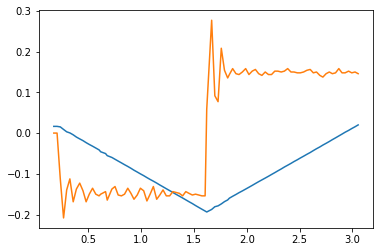

0.014307476741644112


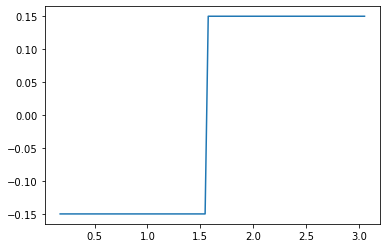

In [22]:

for i in [0, 1]:
    plt.plot(all_time, [s[i] for s in all_states])
plt.show()

print(np.max([x[4] for x in all_states]))

for i in range(1):
    plt.plot(all_time, [cmd[i] for cmd in all_cmd])
plt.show()